In [57]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from hyperplane_LSH import hyperplane_LSH
from hyperplane_LSH import plot_svc_decision_function
from nltk import ngrams

### Lets see how random hyperplanes look with my(Sharwin Bobde) module
we will make 10 random hyperplanes for normal data.
we will aslso have random points from 0-20

In [58]:
# dummy data for 2d plot
X = np.random.uniform(0,20, 100).reshape((50,2))

In [59]:
hyp_LSH = hyperplane_LSH(X, 10)

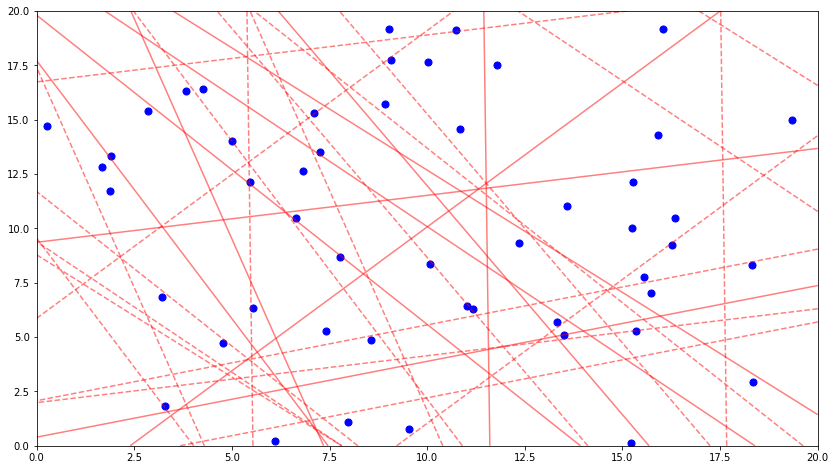

In [60]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((14,8))
ax.set_xlim((0,20))
ax.set_ylim((0,20))
ax.scatter(X[:, 0], X[:, 1], c='blue', s=50, cmap='autumn')
for h in hyp_LSH.H:
    plot_svc_decision_function(h, ax, plot_support=False)


The above figure shows the required random hyperplanes (SVC in this implimenttation) and their margins. Notice the scaling is proper and every run/initialisation generates randomly inistialised hyperplanes.

### Lets get to the task
we will first devide the discretised data according to the rquirement of grouped by source-destination IP adresses.

In [70]:
# import discretised features
df = pd.read_csv("data/TotBytes_Dur_discretized.csv")

groupby_cols = ['SrcAddr', 'DstAddr' ] 
groupby_cols = df[groupby_cols].to_numpy()
groupby_cols_unique = np.unique(groupby_cols, axis=0)

n_grams_IP = []
n_grams = []
# know all possible signatures
pissible_ngrams = np.unique(np.array(list(ngrams(df['TotBytes_Dur'].to_numpy(), 3))), axis=0)
print(pissible_ngrams.shape)

# get signatures (counts of ngrams)
for group in groupby_cols_unique:
    is_in_group =  np.logical_and( groupby_cols[:,0] == group[0], groupby_cols[:,1] == group[1])
    indexes = np.where(is_in_group)
    items = df['TotBytes_Dur'].to_numpy()[indexes]
    temp_grams = list(ngrams(items, 3))

    n_grams_IP.append(group)
    # TODO; generate signature

n_grams_IP = np.array(n_grams_IP)
n_grams = np.array(n_grams)

print(n_grams_IP.shape)
print(n_grams.shape)

(132, 3)
(121267, 2)
(121267, 3)


We have stored the 3-grams in `n_grams` and the corresponfing IP source-destination pair in `n_grams_IP` 

In [71]:
# TODO find true nearest neighbours for a IP pair... also compyte time required

In [ ]:
# TODO find LSH based nearest neighbours for a IP pair... also compyte time required

In [ ]:
# TODO compare error in neighbours (Recall & precission) and time required for changing number of hashing hyperplanes

In [ ]:
# TODO compare best error and corresponding time required